
<img alt='UCL' src="images/ucl_logo.png" align='center'>




# Assessed Practical Part B

## Introduction

### Task overview

In this task, you will be running, calibrating and testing a snowmelt model for a catchment in the Rio Grande Headwaters, Colorado, USA. To run the model, you will need 3 datasets to run the model in this part of the coursework:

- `T` : temperature (C) at the Del Norte monitoring station for each day of the year
- `Q` : stream flow data for each in units of megalitres/day (ML/day i.e. units of 1000000 litres a day)
- `p` : Catchment snow cover (proportion)

The first part of this submission then (30% of marks) involves deriving the snow snow cover data from MODIS satellite data. 

The second part (70%) involves building a 2D parameter Look-up table (LUT) and using this to calibrate the two model parameters for the catchment for a given year. You will then test this calibration against data from another year.

### Submission

The due dates for this second formally assessed piece of coursework is:

        Part B: 11th Jan, 2021 (50% of final mark) - first day of term 2

Recall that the practical comes in two parts : (A) [data preparation (50%)](062_Part1.ipynb); (B) [modelling (50%)](066_Part2.ipynb) 

Submission is through the usual Turnitin link on the [course Moodle page](https://moodle-1819.ucl.ac.uk/course/view.php?id=2796#section-4). You must submit your notebooks and codes as `pdf` files.


### Checklist
    
* There are two parts to this section:

    Snow data preparation [40%]
    Model inversion [60%]    

You should be submitting 4 PDF files:

    * code work/get_snow_cover.py for Snow data preparation [0.8 * 0.4]
    * Snow data preparation notebook                        [0.2 * 0.4]
    * code work/lut_model.py.py for model inversion         [0.7 * 0.6]
    * Model inversion notebook                              [0.3 * 0.6]
    
* None of these files should be more than a few pages long: we do not want you to print or submit the datasets you download.
* Look over the [requirements](#Structure-of-the-Report) to make sure you have completed all parts.
* Make sure you read the advice on [computer codes and plagiarism](063_Part1_code.ipynb)

##  Background

The hydrology of the Rio Grande Headwaters in Colorado, USA is snowmelt dominated. It varies considerably from year to year and may very further under a changing climate. One of the tools we use to understand monitor processes in such an area is a mathemetical ('environmental') model describing the main physical processes affecting hydrology in the catchment. Such a model could help understand current behaviour and allow some prediction about possible future scenarios. 

In this part of your assessment you will be using, calibrating and validating such a model that relates temperature and snow cover in the catchment to river flow. 
![](https://www.blm.gov/sites/blm.gov/files/hero_backgrounds/NM_Rio_Grande_del_Norte_Sign_640.jpg)

We will use the model to describe the streamflow at the Del Norte measurement station, just on the edge of the catchment. You will use environmental (temperature) data and snow cover observations to drive the model. You will perform calibration and testing by comparing model output with observed streamflow data.

### Del Norte

Further general information is available from various [websites](http://www.usclimatedata.com/climate.php?location=USCO0103), including [NOAA](http://www.ncdc.noaa.gov).

![www.coloradofishing.net](http://www.coloradofishing.net/images/fishtails/ft_riogrande3.jpg)



You can visualise the site Del Norte 2E  [here](http://mesonet.agron.iastate.edu/sites/site.php?station=CO2184&network=COCLIMATE).




## Previous work

In [part A](062_Part1.ipynb), you should have developed datasets for four years, 2015-2019 inclusive for:

    * temperature (C) at the Del Norte monitoring station for each day of the year
    * stream flow data for each in units of megalitres/day (ML/day i.e. units of 1000000 litres a day)
    
as a function of day of year (`doy`).
    
**You will use these datasets in part 2 of this work.**

If for some reason, you are unable to produce the datasets in [part A](062_Part1.ipynb) you should contact one of the course conveners to discuss what to do.

|   |  | 
|---|---|
|[Prof P. Lewis](https://search2.ucl.ac.uk/s/search.html?query=philip+lewis+geography&collection=website-meta&profile=_directory&tab=directory)|[Dr Qingling Wu](https://search2.ucl.ac.uk/s/search.html?query=qingling+wu&collection=website-meta&profile=_directory&tab=directory)| 


## The model

As we have noted, you will be running, calibrating and testing a snowmelt model in the Rio Grande Headwaters in Colorado, USA. To run the model, you will need 3 datasets to run the model in this part of the coursework:

- `T` : temperature (C) at the Del Norte monitoring station for each day of the year
- `Q` : stream flow data for each in units of megalitres/day (ML/day i.e. units of 1000000 litres a day)
- `p` : Catchment snow cover (proportion)

The first part of this submission then involves deriving the snow snow cover data from MODIS satellite data. We will explain this below.

First, we should familiarise ourselves with the model. 

The model state is the snow water equivalent (SWE), the amount of water in the snowpack for the catchment. We assume this is directly proportional to snow cover `p`, so:

    SWE(t) ~= p
    
with a constant of proportionality relating to snow depth and density. 

We model the rate of release of water from the snowpack as a logistic function of temperature:

    m = expit(T-T0)
    
where `expit` the [logistic function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html) that we have previously used in phenology modelling.

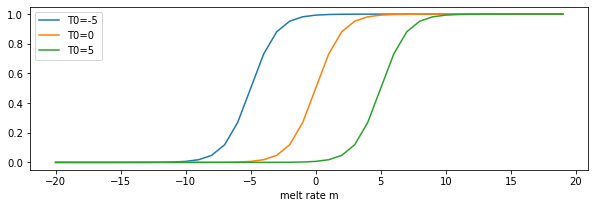

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

# temperature
T = np.arange(-20,20)
fig, axs = plt.subplots(1,1,figsize=(10,3))
axs.set_xlabel("temperature / C")
axs.set_xlabel("melt rate m")

for T0 in [-5,0,5]:
    m = expit(T-T0)
    axs.plot(T,m,label=f'T0={T0}')
axs.legend(loc='best')

This is a convenient 'soft switch' function that is widely used in modelling and  computing. If the temperature is much less that `T0` then `m` is 0. If it is much greater, them `m` is 1. For a transition zone around `T0`, it varies smoothly.

The water release from the snow pack is now proportional to `p m`, so is controlled by temperature and current snow cover. We now load up some example datasets of temperature, snow cover and flow. You are *not* to use these in your submission. They are for illustration only.

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
'''
Load example data
'''
pkl_file = open('data/data2005.pkl', 'rb')
# note encoding='latin1' because pickle generated in python2
data = pickle.load(pkl_file, encoding='latin1')
pkl_file.close()

T = data['temp']
# we normalise the flow data by subtracting the base level and 
# making it sum to 1, you should do the same
# or you will need to supply a scaling factor

Q = data['flow'] - data['flow'].min()
Q /= Q.sum()

p = data['snowprop']
t = data['doy']

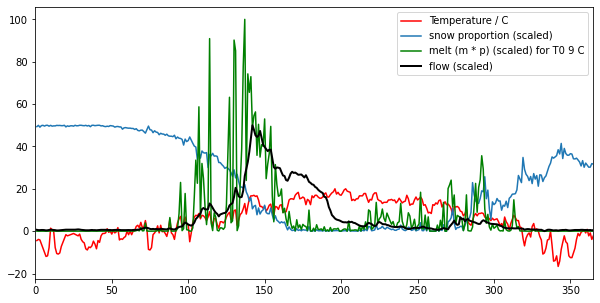

In [3]:
fig, axs = plt.subplots(1,1,figsize=(10,5))
T0 = 9
m = expit(T-T0)
# m * p
mp = m * p
mp /= mp.sum()

axs.plot(t,T,'r',label='Temperature / C')
axs.plot(t,50 * p,label='snow proportion (scaled)')
axs.plot(t,100 * mp/mp.max(),'g',label=f'melt (m * p) (scaled) for T0 {T0} C')
axs.plot(t,50 * Q/Q.max(),'k',lw=2,label='flow (scaled)')

axs.set_xlim(0,365)
axs.legend(loc='best')

In the figure, we see the melt water that corresponds to a temperature of 9 degrees. It is remarkably similar to the flow data, but much noisier. We also see that it occurs some time before we see the water flow at the me=onitoring station. The reason for this is that there is a 'network delay' between the melt happening in thge snopack and it reaching the monitoring station. This final component of our model is a network response function (NRF) that models this delay:

Text(0.5, 0, 'time')

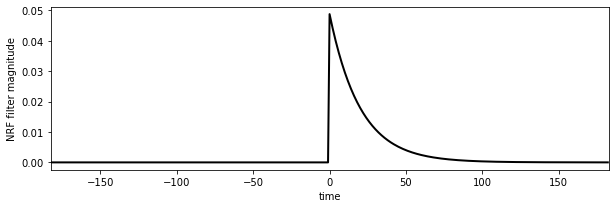

In [4]:
# build the NRF filter
#
# use centred filter time 
# parameter f = 0.05

f = 0.05

nrf_x = (np.arange(p.size) - p.size//2)
nrf = np.exp(-f*nrf_x)    
# 1-sided NRF filter
nrf[nrf_x<0] = 0
# normalise so sum to 1
nrf /= nrf.sum()

fig, axs = plt.subplots(1,1,figsize=(10,3))
axs.plot(nrf_x,nrf,'k',lw=2,label='flow (scaled)')
axs.set_xlim(-p.size/2,p.size/2)
axs.set_ylabel('NRF filter magnitude')
axs.set_xlabel('time')

The NRF is effectively a one-sided smoothing filter. It imparts a delay on the signal, and smooths it. 

If we look at the cumulative effect of the filter using `np.cumsum`, we can see how long it takes for the water to reach the monitoring station:

(0.0, 1.0)

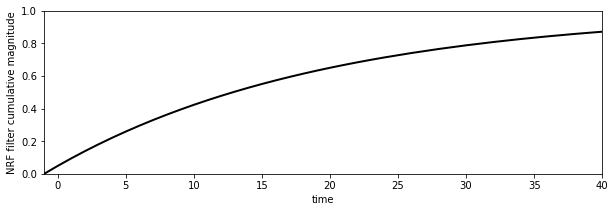

In [5]:
fig, axs = plt.subplots(1,1,figsize=(10,3))
axs.plot(nrf_x,np.cumsum(nrf),'k',lw=2,label='flow (scaled)')
axs.set_xlim(-p.size/2,p.size/2)
axs.set_ylabel('NRF filter cumulative magnitude')
axs.set_xlabel('time')
axs.set_xlim(-1,40)
axs.set_ylim(0,1)

According to this mode, with this parameter, about half of the melt water has reached the monitoring station after around 15 days.

If we convolve this filter with out signal `m p`, we have our complete model. It is a very simple model that has only 2 parameters: `T0` and `f`, although we have assumed the flow data to be normalised to sum to 1 to avoid an additional scaling factor.

We can now see the code for the model (also in [geog0111/model.py](geog0111/model.py)):

In [6]:
from scipy.special import expit
import scipy
import scipy.ndimage.filters

def model(T0,f,T,p,xp=1.0):
    '''
    snow melt model
    
    parameters:
        T0 - Temperature threshold (C): float or shape (Np)
             Typical range: 0.0 to 20.0
        f  - NRF filter decay rate    : float or shape (Np)
             Trypical range: 0.05 to 0.2
    Drivers:
        T  - Temperature (C)         : shape (Nd,)
        p  - snow cover (proportion) : shape (Nd,)
        
    Option:
        xp - float. logistic decay rate in Temperature function 
             typical range 1.0-4.0
    
    Output:
    
        Normalised river flow resulting from snowmelt. 
        Normalised to sum to 1.0 over all days
    '''
    # force T0 and f into 1D -> arrays
    f = np.array(f).ravel()[np.newaxis,:]
    T0 = np.array(T0).ravel()[np.newaxis,:]
    # treat T and p into 1D -> 2D arrays
    T = T.ravel()[:,np.newaxis]
    p = p.ravel()[:,np.newaxis]
    
    # logistic for temperature threshold effect
    y = p * expit(xp*(T-T0))
    
    # centred filter time 
    nrf_x = (np.arange(p.shape[0]) - p.shape[0]/2)
    # 1-sided NRF filter
    nrf = np.exp(-f*nrf_x[:,np.newaxis])    
    nrf[nrf_x<0,:] = 0
    
    # modelled flow : loop is inefficent by 
    # necessary if using convolution routine
    Q_nrf = np.array([scipy.ndimage.filters.convolve1d(y[:,i], nrf[:,i]) \
                       for i in range(y.shape[1])]).T
    return Q_nrf/Q_nrf.sum(axis=0)

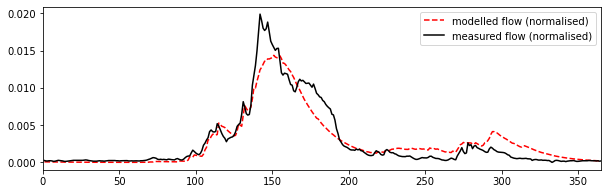

In [7]:
# Run the model
T0,f = 9,0.05
# T and p are input time series
Q_nrf = model(T0,f,T,p).ravel()

fig, axs = plt.subplots(1,1,figsize=(10,3))
axs.plot(t,Q_nrf,'r--',label=f'modelled flow (normalised)')
axs.plot(t,Q,'k',label='measured flow (normalised)')

axs.set_xlim(0,365)
axs.legend(loc='best')

The model appears to be capable of following the features of the measured flow data quite well, although it its slightly over-smoothed.

So, we have defined a simple snow melt model. It has two parameters that we3 can vary:

* `T0`: the lower temperature threshold
* `m`: the network response function decay factor

The modelled flow is normalised so that the total flow equals the total measured flow. The base flow is subtracted from the data so that the minimum flow is zero.

## Coursework

There are two sections to part B of your coursework:
    
1. Snow data preparation `[40%]`
2. Model inversion `[60%]`

40% of the marks for this section are given for the snow data pretation, and 60% for the model inversion.

## Snow data preparation 


### MODIS data 

The aim of this section is for you to produce datasets of snow cover for the Hydrological Unit Code (HUC code)  catchment 13010001 (Rio Grande headwaters in Colorado, USA) using MODIS snow cover data. You should by now have plenty of experience of accessing and using the MODIS LAI product, and we have already come across the snow product in [030_NASA_MODIS_Earthdata](030_NASA_MODIS_Earthdata.ipynb). 

For this section, you must:

* create a Python file called `work/get_snow_cover.py` that when you run it, creates and stores a measured snow cover dataset, for each day of the year, averaged over over HUC catchment 13010001. It should store the data in a CSV format file called `work/snow_cover_YYYY.csv` for year YYYY. It should produce data files for both 2018 and 2019. You should submit this code as a PDF.
* From a function in `work/get_snow_cover.py` you should plot and save graphs showing the snow cover datasets you have generated.
* Run the script from a terminal prompt or Jupyter notebook and show the size and dates of the files created.

20% of the marks for this section will be for the content and quality of your plots. The rest will be for the code you produce. You should submit a single PDF file for the code, and another for the evidence of the file sizes and the graphs. Neither of these PDFs should be more than a few pages long.

#### Advice

You will need this snow cover dataset, along with those you generated in Part A of your coursework
You will want to use the product `MOD10A1` for the years 2018 and 2019. You should apply the catchment boundary vector dataset in the file [data/Hydrologic_Units/HUC_Polygons.shp](data/Hydrologic_Units/HUC_Polygons.shp) to clip your region of interest, specifying the warp arguments and other parameters as follows:

        sds     = ['NDSI_Snow_Cover']
        product = 'MOD10A1'
        tile = ['h09v05']
        
        warp_args = {
          'dstNodata'     : 255,
          'format'        : 'MEM',
          'cropToCutline' : True,
          'cutlineWhere'  : f"HUC=13010001",
          'cutlineDSName' : 'data/Hydrologic_Units/HUC_Polygons.shp'
        }

You can the use a function such as [`modis_annual`](geog0111/modis_annual.py) as previously to gather the dataset for the two years of interest. Since the function  [`modis_annual`](geog0111/modis_annual.py) is able to cache the dataset, you might like to run it the first time from a shell, with the vebose flag switched on. It may take some considerable time to stitch all of the data together, so being able to see the progress from the verbose output will be important.

You will use one year for model calibration and the other for model validation. As the dataset may have gaps, you should use the regularisation approach we have taken previously for LAI to fill the gaps. 

The dataset you produce for each year should have 365 days of snow cover data. It should broadly look like the example shown above. If your dataset appears too 'spikey', it may well be that you have forgotten to apply the regularisation/gap filling.

All of the marks for this section are on the code you submit, along with the file sizes and graphs demonstrating that you code works as expected.


## Model inversion

You should have access to datasets for

- `T` : temperature (C) at the Del Norte monitoring station for each day of the year
- `Q` : stream flow data for each in units of megalitres/day (ML/day i.e. units of 1000000 litres a day)
- `p` : Catchment snow cover (proportion)

for the years 2018 and 2019. If, for any reason you have been able to produce these, discuss the matter with your course tutors before completing this section.


|   |  | 
|---|---|
|[Prof P. Lewis](https://search2.ucl.ac.uk/s/search.html?query=philip+lewis+geography&collection=website-meta&profile=_directory&tab=directory)|[Dr Qingling Wu](https://search2.ucl.ac.uk/s/search.html?query=qingling+wu&collection=website-meta&profile=_directory&tab=directory)| 

* Use a LUT approach to calibrate the 2-parameter snowmelt model presented above for one of your years of data. You should do this with code in a Python file `work/lut_model.py`. In the same file, use the other year of data to validate the model, i.e. run the model for the second year with the parameters you derived from the first (calibration) year. You should produce *and save* appropriate graphs/parameter plots (e.g. time series of the measured and modelled data, image plots of the RMSE, with the minimum plotted on the top, as we have demonstrated in the notes). Submit `work/lut_model.py` as a PDF file.
* From a Jupyter notebook, run the script `work/lut_model.py`, and load the graphs you have saved into the notebook. Produce tables showing the model parameters.

70% of the marks for this section will be awarded for the computer code, and 30% for the graphs and tables. 

You need to submit you coursework in the usual manner by the usual submission date.

You **must** work individually on this task. If you do not, it will be treated as plagiarism. By reading these instructions for this exercise, we assume that you are aware of the UCL rules on plagiarism. You can find more information on this matter in your student handbook. If in doubt about what might constitute plagiarism, ask one of the course conveners. You should read the [advice on plagiarism and computer codes](063_Part1_code.ipynb) we have supplied.